In [47]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [51]:
dataset=pd.read_csv('SolarPrediction_aligned_Sun.csv',engine='python',nrows=576*15)
dataset=dataset.drop("Data",axis=1)
dataset=dataset.drop("Time",axis=1)
# dataset=dataset.drop("TimeSunRise",axis=1)
# dataset=dataset.drop("TimeSunSet",axis=1)
#target=dataset["Radiation"]
dataset.head(5)

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,8,2.58,51,30.43,103,77.27,11.25,22020,67080
1,310,2.83,51,30.43,103,153.44,9.00,22020,67080
2,1206,2.16,51,30.43,103,142.04,7.87,22020,67080
3,1505,2.21,51,30.43,103,144.12,18.00,22020,67080
4,1809,2.25,51,30.43,103,67.42,11.25,22020,67080


In [50]:
# dataset=dataset.values
# dataset[0,0:9]

array([8.000e+00, 2.580e+00, 5.100e+01, 3.043e+01, 1.030e+02, 7.727e+01,
       1.125e+01, 2.202e+04, 6.708e+04])

In [52]:
dataset=dataset.values

dataset=dataset.astype('float32')

scalar1=MinMaxScaler(feature_range=(0,1))
scalar2=MinMaxScaler(feature_range=(0,1))
scalar_dim=dataset[:,1]
dataset=scalar1.fit_transform(dataset)

scalar_dim=scalar_dim.reshape(len(dataset),1)
print(scalar_dim)
scalar_dim=scalar2.fit_transform(scalar_dim)
print(scalar_dim)

[[  2.58]
 [  2.83]
 [  2.16]
 ...
 [344.9 ]
 [365.66]
 [355.57]]
[[0.00089369]
 [0.00104993]
 [0.00063121]
 ...
 [0.21482898]
 [0.2278031 ]
 [0.22149728]]


In [53]:
train_size=int(len(dataset)*0.67)
test_size=len(dataset)- train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]

In [54]:
def create_dataset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        #a=dataset第0行i~i+look_back個
        #參考資料數9個
        a=dataset[i:(i+look_back),0:9]
        dataX.append(a)
        dataY.append(dataset[i+look_back,1])
    return np.array(dataX),np.array(dataY)

In [55]:
#根據前面幾個資料來看下一步 彙整成look_back行的資料
look_back=5
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)

In [58]:

def create_lstm_model(trial):
    # 創建LSTM模型
    model = Sequential()

    # 設定超參數空間
    units = trial.suggest_int('units', 1, 128, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    
    # 添加LSTM層
    model.add(LSTM(units=units, activation=activation, input_shape=(look_back,9)))
    
    # 添加Dropout層
    model.add(Dropout(rate=dropout_rate))

    # 添加最終的密集層
    model.add(Dense(1))

    return model

In [59]:
objective_values = []
def objective(trial):
    # 創建LSTM模型
    model = create_lstm_model(trial)

    # 編譯模型
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 訓練模型
    model.fit(trainX, trainY, epochs=10, batch_size=1, validation_split=0.2, verbose=0)

    # 預測測試集
    testPre = model.predict(testX)

    testPre=scalar2.inverse_transform(testPre)
    testY_ord=scalar2.inverse_transform([testY])

    # 計算均方誤差
    rmse = math.sqrt(mean_squared_error(testY_ord[0,:],testPre[:,0]))
    objective_values.append(rmse)
    # 返回均方誤差，Optuna會嘗試最小化這個值
    return rmse


In [60]:
# 創建Optuna優化study

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 獲得最佳超參數
best_params = study.best_params
print("最佳超參數：", best_params)

[I 2024-01-27 12:36:35,102] A new study created in memory with name: no-name-51db3d13-4712-4a0a-95a6-8cbc645b80af


89/89 [==============================] - 0s 3ms/step


[I 2024-01-27 12:36:43,285] Trial 0 finished with value: 122.7328866248857 and parameters: {'units': 7, 'activation': 'relu', 'dropout_rate': 0.18168117697142228}. Best is trial 0 with value: 122.7328866248857.


89/89 [==============================] - 1s 2ms/step


[I 2024-01-27 12:36:54,537] Trial 1 finished with value: 92.01911522742962 and parameters: {'units': 97, 'activation': 'tanh', 'dropout_rate': 0.42340330055676334}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 0s 3ms/step


[I 2024-01-27 12:37:01,357] Trial 2 finished with value: 190.52136984168837 and parameters: {'units': 1, 'activation': 'relu', 'dropout_rate': 0.26191694503596685}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 1s 2ms/step


[I 2024-01-27 12:37:10,128] Trial 3 finished with value: 117.3570924836395 and parameters: {'units': 3, 'activation': 'tanh', 'dropout_rate': 0.07720541963569055}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 0s 2ms/step


[I 2024-01-27 12:37:18,161] Trial 4 finished with value: 98.4355030686427 and parameters: {'units': 59, 'activation': 'relu', 'dropout_rate': 0.03179924267903256}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 0s 2ms/step


[I 2024-01-27 12:37:26,162] Trial 5 finished with value: 98.99882678803621 and parameters: {'units': 21, 'activation': 'relu', 'dropout_rate': 0.050915014438727424}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 1s 2ms/step


[I 2024-01-27 12:37:35,460] Trial 6 finished with value: 96.23399500772322 and parameters: {'units': 4, 'activation': 'tanh', 'dropout_rate': 0.1839401539736944}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 1s 2ms/step


[I 2024-01-27 12:37:44,412] Trial 7 finished with value: 144.13782194280367 and parameters: {'units': 2, 'activation': 'tanh', 'dropout_rate': 0.3269702343372285}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 0s 2ms/step


[I 2024-01-27 12:37:52,040] Trial 8 finished with value: 164.97403129517892 and parameters: {'units': 3, 'activation': 'relu', 'dropout_rate': 0.305099515805505}. Best is trial 1 with value: 92.01911522742962.


89/89 [==============================] - 0s 2ms/step


[I 2024-01-27 12:37:58,866] Trial 9 finished with value: 161.9771779082531 and parameters: {'units': 1, 'activation': 'relu', 'dropout_rate': 0.09608044199329036}. Best is trial 1 with value: 92.01911522742962.


最佳超參數： {'units': 97, 'activation': 'tanh', 'dropout_rate': 0.42340330055676334}


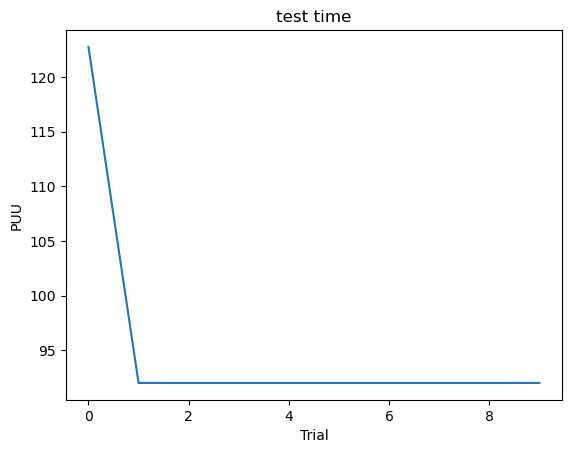

In [61]:
temp=objective_values[0]
for i in range(0,len(objective_values)):
    if objective_values[i] >temp:
        objective_values[i]=temp
    elif temp>objective_values[i]:
        temp=objective_values[i]

    
plt.plot(objective_values,label="best PUU")
plt.title('test time')
plt.xlabel('Trial')
plt.ylabel('PUU')
plt.show()
